# Exploratory Data Analysis

In [1]:
import datetime
import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Specify database path
db = '../../data/database.sqlite'

### Filtering out unnecessary attributes and observations 

I began EDA by loading the required tables from the database specified above.

In [3]:
# Load data tables
country = data.read('country', db)
league = data.read('league', db)
match = data.read('match', db)
team = data.read('team', db)
team_attributes = data.read('team_attributes', db)

country: loaded
league: loaded
match: loaded
team: loaded
team_attributes: loaded


The predictive model will be fitted on just the English Premier League (EPL) match data. Note that `league_id` for EPL  is 1729. This variable can be changed to fit predictive models for other leagues. The code below filters out matches that were not played in EPL and attributes that are not required for the model.

In [4]:
# Initiate variable for EPL league ID 
league_id = 1729

# Create a column to specify which team won the match; this will server as the response variable in the model
epl_matches = match[(match['league_id'] == league_id)]
epl_matches['result'] = np.where(epl_matches['home_team_goal'] > epl_matches['away_team_goal'], 'home' , 
                        np.where(epl_matches['home_team_goal'] == epl_matches['away_team_goal'], 'draw' , 'away'))

# Create a field for season year
epl_matches['season_year'] = pd.to_numeric(epl_matches['season'].str[:4])

# Leave out unnecessary attributes
epl_matches = epl_matches[['match_api_id', 'league_id', 'season_year', 'home_team_api_id', 'away_team_api_id', 'result']].reset_index(drop = True)

epl_matches.head()

,match_api_id,league_id,season_year,home_team_api_id,away_team_api_id,result
0,489042,1729,2008,10260,10261,draw
1,489043,1729,2008,9825,8659,home
2,489044,1729,2008,8472,8650,away
3,489045,1729,2008,8654,8528,home
4,489046,1729,2008,10252,8456,home


Next, team attribute table was filtered to just include EPL teams

In [5]:
# Create an mapping of EPL teams 
epl_mapping = pd.DataFrame(pd.concat([epl_matches['home_team_api_id'], epl_matches['away_team_api_id']], ignore_index = True).unique())
epl_mapping.columns = ['team_api_id']

# Filter out data to only include EPL teams
epl_teams = team_attributes.merge(epl_mapping, on = 'team_api_id', how = 'inner')

# Create a column for year
epl_teams['year'] = pd.DatetimeIndex(epl_teams['date']).year

# Add team name and drop other  unnecessary fields
epl_teams = epl_teams.merge(team[['team_api_id', 'team_long_name']], on = 'team_api_id', how = 'left').drop(['id', 'team_fifa_api_id', 'date'], axis = 1)

### Combine data tables

To build a classification model, I combined the two tables created above: `epl_teams` and `epl_matches`. To combine the tables, I joined the tables on both the team ID as well as season year. The inner join in this case was done twice to add team attributes for both the home and away teams. Finally, I removed fields that would not be considered in the model. 

In [6]:
# Add home team attributes
data = pd.merge(epl_matches, epl_teams, how = 'inner', left_on = ['home_team_api_id', 'season_year'], right_on = ['team_api_id', 'year'])
data = pd.merge(data, epl_teams, how = 'inner', left_on = ['away_team_api_id', 'season_year'], right_on = ['team_api_id', 'year'], suffixes = ('_home', '_away')) \
         .drop(['league_id', 'year_home', 'year_away', 'match_api_id', 'buildUpPlayDribbling_home', 'buildUpPlayDribbling_away', 'home_team_api_id', 'away_team_api_id', 'team_api_id_home', 'team_api_id_away'], axis = 1)
data.head()

,season_year,result,buildUpPlaySpeed_home,buildUpPlaySpeedClass_home,buildUpPlayDribblingClass_home,buildUpPlayPassing_home,buildUpPlayPassingClass_home,buildUpPlayPositioningClass_home,chanceCreationPassing_home,chanceCreationPassingClass_home,...,chanceCreationShootingClass_away,chanceCreationPositioningClass_away,defencePressure_away,defencePressureClass_away,defenceAggression_away,defenceAggressionClass_away,defenceTeamWidth_away,defenceTeamWidthClass_away,defenceDefenderLineClass_away,team_long_name_away
0,2010,home,70,Fast,Little,59,Mixed,Organised,65,Normal,...,Normal,Organised,30,Deep,70,Double,30,Narrow,Cover,West Ham United
1,2010,draw,55,Balanced,Little,70,Long,Organised,60,Normal,...,Normal,Organised,30,Deep,70,Double,30,Narrow,Cover,West Ham United
2,2010,home,55,Balanced,Little,70,Long,Organised,70,Risky,...,Normal,Organised,30,Deep,70,Double,30,Narrow,Cover,West Ham United
3,2010,home,70,Fast,Little,60,Mixed,Free Form,56,Normal,...,Normal,Organised,30,Deep,70,Double,30,Narrow,Cover,West Ham United
4,2010,home,50,Balanced,Little,35,Mixed,Organised,50,Normal,...,Normal,Organised,30,Deep,70,Double,30,Narrow,Cover,West Ham United


### Examine each categorical and numerical attributes

I split up categorical and numerical variables to create summary tables.

In [7]:
# Specify fields that are numerical and categorical
numerical = list(data.describe())
categorical = ['buildUpPlaySpeedClass_home', 'buildUpPlayDribblingClass_home', 
               'buildUpPlayPassingClass_home', 'buildUpPlayPositioningClass_home', 'chanceCreationPassingClass_home',
               'chanceCreationCrossingClass_home', 'chanceCreationShootingClass_home', 'chanceCreationPositioningClass_home',
               'defencePressureClass_home', 'defenceAggressionClass_home', 'defenceTeamWidthClass_home',
               'defenceDefenderLineClass_home', 'team_long_name_home', 'buildUpPlaySpeedClass_away',
               'buildUpPlayDribblingClass_away', 'buildUpPlayPassingClass_away', 'buildUpPlayPositioningClass_away', 
               'chanceCreationPassingClass_away', 'chanceCreationCrossingClass_away', 'chanceCreationShootingClass_away', 
               'chanceCreationPositioningClass_away','defencePressureClass_away', 'defenceAggressionClass_away',
               'defenceTeamWidthClass_away', 'defenceDefenderLineClass_away', 'team_long_name_away']

In [8]:
# Convert data type as 'category'
for i in categorical:
    data[i] = data[i].astype('category')

In [9]:
# Create summary table for categorical variables
data.describe(include = ['category'])

,buildUpPlaySpeedClass_home,buildUpPlayDribblingClass_home,buildUpPlayPassingClass_home,buildUpPlayPositioningClass_home,chanceCreationPassingClass_home,chanceCreationCrossingClass_home,chanceCreationShootingClass_home,chanceCreationPositioningClass_home,defencePressureClass_home,defenceAggressionClass_home,...,buildUpPlayPositioningClass_away,chanceCreationPassingClass_away,chanceCreationCrossingClass_away,chanceCreationShootingClass_away,chanceCreationPositioningClass_away,defencePressureClass_away,defenceAggressionClass_away,defenceTeamWidthClass_away,defenceDefenderLineClass_away,team_long_name_away
count,2280,2280,2280,2280,2280,2280,2280,2280,2280,2280,...,2280,2280,2280,2280,2280,2280,2280,2280,2280,2280
unique,3,2,3,2,3,3,3,2,3,3,...,2,3,3,3,2,3,3,3,1,32
top,Balanced,Little,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,...,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover,Liverpool
freq,1786,1672,1672,2166,1843,1615,1900,1862,1957,2014,...,2166,1843,1615,1900,1862,1957,2014,2166,2280,114


In [10]:
# Create summary for numerical variables
data.describe()

,season_year,buildUpPlaySpeed_home,buildUpPlayPassing_home,chanceCreationPassing_home,chanceCreationCrossing_home,chanceCreationShooting_home,defencePressure_home,defenceAggression_home,defenceTeamWidth_home,buildUpPlaySpeed_away,buildUpPlayPassing_away,chanceCreationPassing_away,chanceCreationCrossing_away,chanceCreationShooting_away,defencePressure_away,defenceAggression_away,defenceTeamWidth_away
count,2280.0000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000
mean,2012.5000,56.566667,52.141667,50.725000,57.283333,52.366667,44.775000,50.391667,50.825000,56.566667,52.141667,50.725000,57.283333,52.366667,44.775000,50.391667,50.825000
std,1.7082,10.772486,12.883881,11.235572,11.260936,11.180506,9.842943,10.734934,8.545549,10.772486,12.883881,11.235572,11.260936,11.180506,9.842943,10.734934,8.545549
min,2010.0000,25.000000,24.000000,28.000000,31.000000,24.000000,25.000000,31.000000,30.000000,25.000000,24.000000,28.000000,31.000000,24.000000,25.000000,31.000000,30.000000
25%,2011.0000,48.000000,43.500000,42.000000,50.000000,45.750000,38.000000,41.000000,45.000000,48.000000,43.500000,42.000000,50.000000,45.750000,38.000000,41.000000,45.000000
50%,2012.5000,58.500000,51.000000,49.500000,59.000000,54.000000,44.000000,50.000000,51.000000,58.500000,51.000000,49.500000,59.000000,54.000000,44.000000,50.000000,51.000000
75%,2014.0000,65.000000,61.000000,59.250000,68.250000,60.000000,50.250000,58.000000,56.000000,65.000000,61.000000,59.250000,68.250000,60.000000,50.250000,58.000000,56.000000
max,2015.0000,77.000000,80.000000,72.000000,76.000000,80.000000,70.000000,70.000000,70.000000,77.000000,80.000000,72.000000,76.000000,80.000000,70.000000,70.000000,70.000000


Below is the correlation table for the numerical variables. There doesn't seem to be a serious multicollinearity issue in the dataset. 

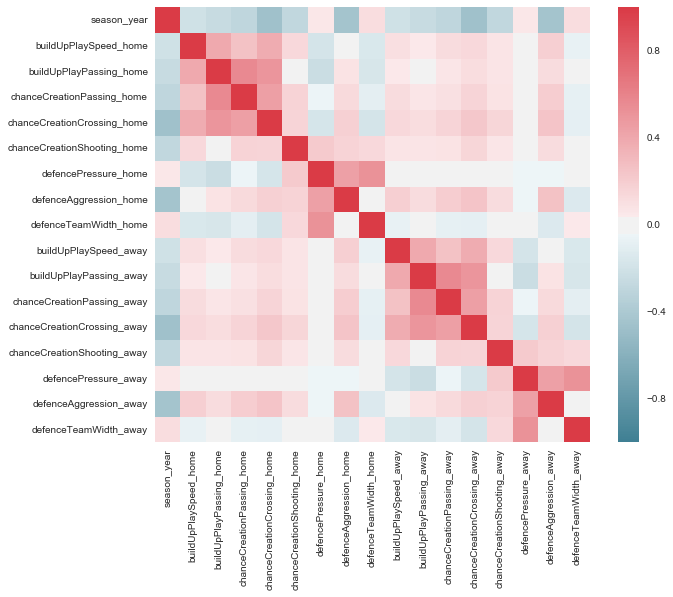

In [11]:
# Plot correlation table
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask = np.zeros_like(corr, dtype = np.bool), cmap = sns.diverging_palette(220, 10, as_cmap = True), square = True, ax = ax)
plt.show()

Below is the distribution of each numerical variable except for `season year`. It looks like we don't have any variables that are heavily skewed.

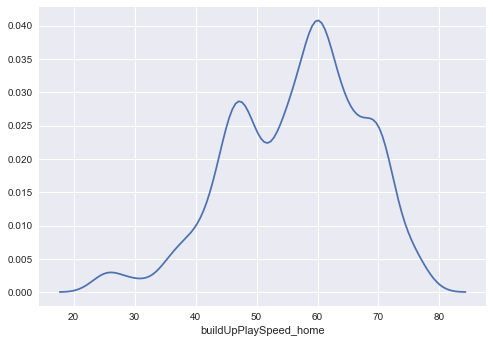

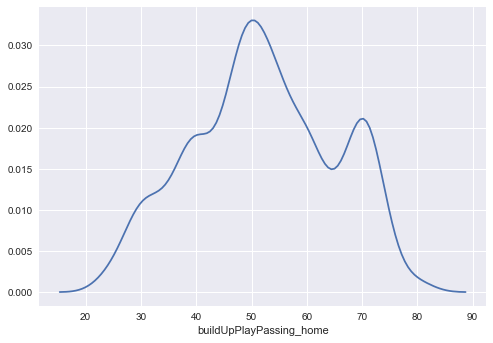

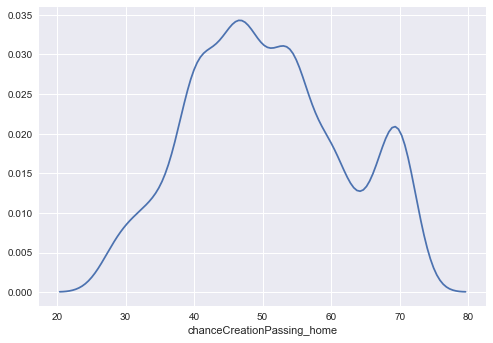

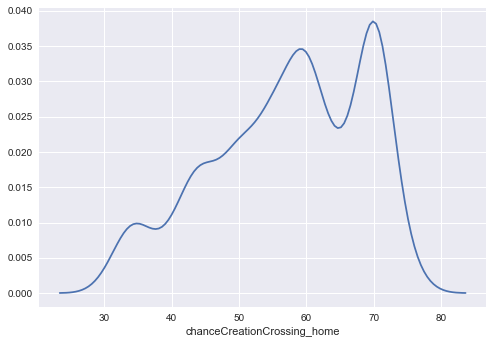

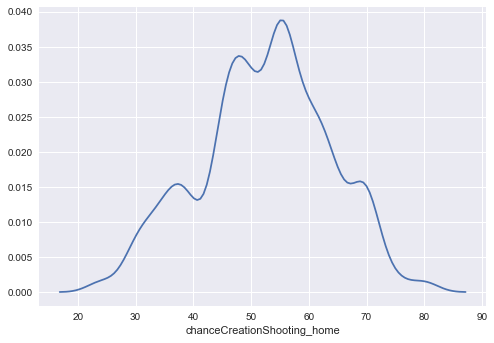

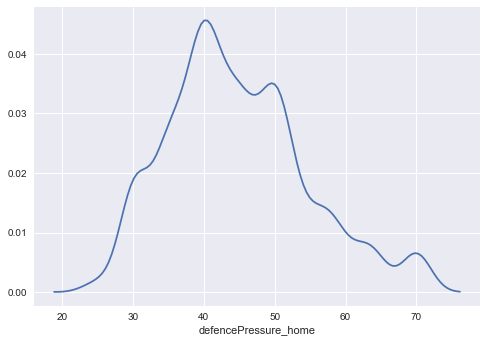

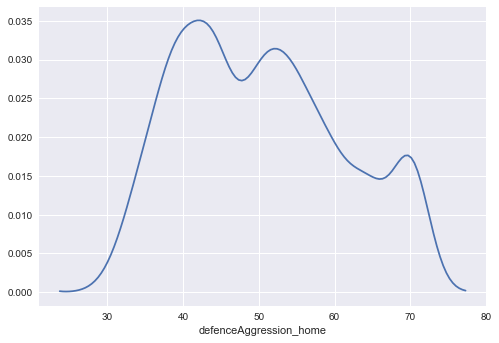

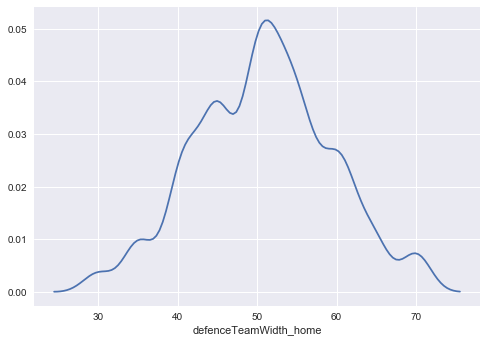

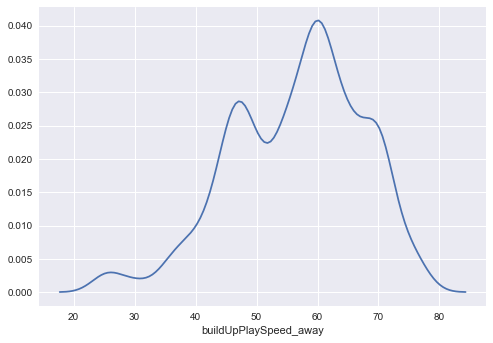

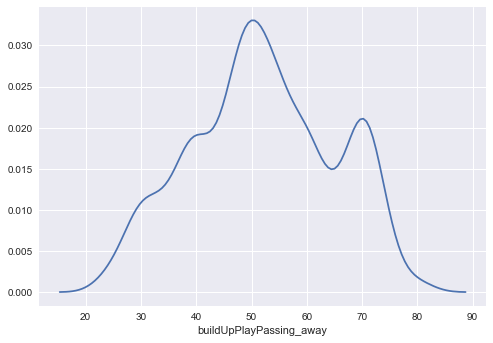

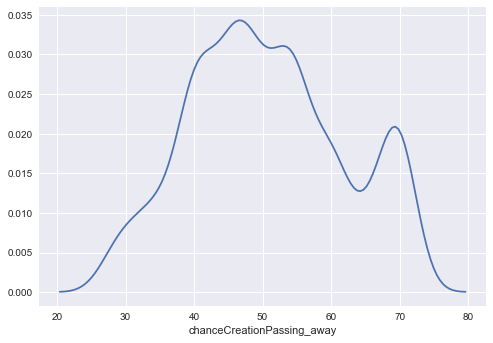

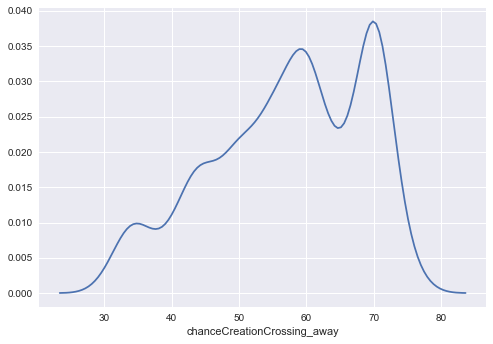

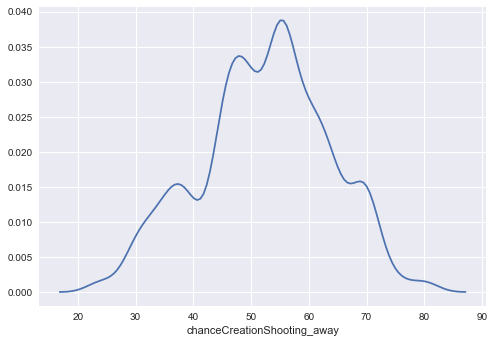

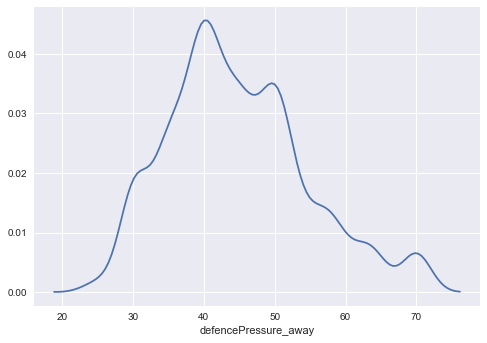

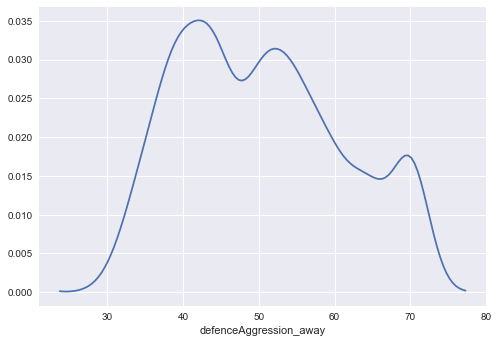

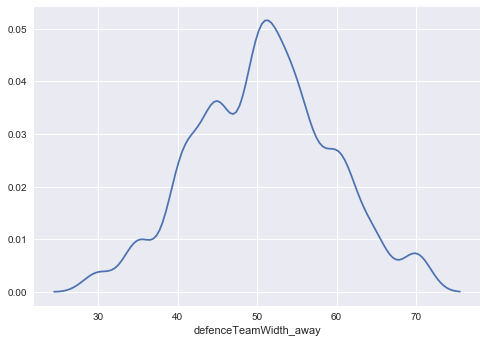

In [12]:
# View distribution tables
for i in numerical[1:]:
    sns.distplot(data[i], hist = False)
    plt.show()

### Fitting initial model

For this application, I will be fitting a simple logistic regression model to the data. Note that I will not be taking a rigorous approach in tuning the model through various methods (e.g. cross validation, variable selction, etc.), and as a result, the predictive power of the model is not optimal. 

In [13]:
# Create dummy variables
dummy = pd.get_dummies(data, columns = categorical)
dummy.head()

,season_year,result,buildUpPlaySpeed_home,buildUpPlayPassing_home,chanceCreationPassing_home,chanceCreationCrossing_home,chanceCreationShooting_home,defencePressure_home,defenceAggression_home,defenceTeamWidth_home,...,team_long_name_away_Southampton,team_long_name_away_Stoke City,team_long_name_away_Sunderland,team_long_name_away_Swansea City,team_long_name_away_Tottenham Hotspur,team_long_name_away_Watford,team_long_name_away_West Bromwich Albion,team_long_name_away_West Ham United,team_long_name_away_Wigan Athletic,team_long_name_away_Wolverhampton Wanderers
0,2010,home,70,59,65,70,50,30,70,30,...,0,0,0,0,0,0,0,1,0,0
1,2010,draw,55,70,60,70,55,45,70,45,...,0,0,0,0,0,0,0,1,0,0
2,2010,home,55,70,70,70,45,35,70,35,...,0,0,0,0,0,0,0,1,0,0
3,2010,home,70,60,56,70,70,30,60,35,...,0,0,0,0,0,0,0,1,0,0
4,2010,home,50,35,50,60,70,40,60,40,...,0,0,0,0,0,0,0,1,0,0


In [14]:
# Split data into response and predictors
y = dummy['result']
x = dummy.drop('result', axis=1)

# Create database of team attributes for future predictions
team_stats = x[(x['season_year'] == 2015)]

# Create training and test data tables
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .3, random_state = 25)

# Fit logistic model
logreg = LogisticRegression().fit(x_train, y_train)

# Print out prediction accuracy for the data
print('Model accuracy on train set: {:.2f}'.format(logreg.score(x_train, y_train)))
print('Model accuracy on test set: {:.2f}'.format(logreg.score(x_test, y_test)))

Model accuracy on train set: 0.57
Model accuracy on test set: 0.47


### Test out a prediction

In [15]:
home = 'Manchester United'
away = 'Chelsea'
season = 2017

test = team_stats[(team_stats['team_long_name_home_' + home] == 1) & (team_stats['team_long_name_away_' + away] == 1)]
test['season_year'] = season

print(logreg.predict_proba(test))
print('Match prediction: ' + logreg.predict(test)[0])

[[ 0.26391127  0.20446562  0.53162311]]
Match prediction: home
